In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
# Function to extract MFCC + delta features from audio files
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate MFCC and delta features
    combined = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=0)
    combined_scaled = np.mean(combined.T, axis=0)
    
    return combined_scaled


In [3]:
# Function to load the dataset and extract features for each file
def load_dataset(data_path):
    labels = []
    features = []
    for speaker in os.listdir(data_path):
        speaker_path = os.path.join(data_path, speaker)
        if os.path.isdir(speaker_path):
            for file in os.listdir(speaker_path):
                file_path = os.path.join(speaker_path, file)
                if file_path.endswith('.wav'):
                    features.append(extract_features(file_path))
                    labels.append(speaker)
    return np.array(features), np.array(labels)

# Load dataset
data_path = r"C:\Users\Hp\Downloads\Speech Recognition System\dataset"
features, labels = load_dataset(data_path)


In [4]:
# Encode labels (speaker names)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)


In [5]:
# Build the neural network model with Batch Normalization
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model with RMSprop optimizer
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4532 - loss: 1.7812 - val_accuracy: 0.2635 - val_loss: 17.5167
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8489 - loss: 0.5125 - val_accuracy: 0.2096 - val_loss: 13.2658
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8543 - loss: 0.4472 - val_accuracy: 0.3832 - val_loss: 9.4209
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8912 - loss: 0.2940 - val_accuracy: 0.3413 - val_loss: 6.7273
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9148 - loss: 0.2989 - val_accuracy: 0.4072 - val_loss: 4.1846
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8992 - loss: 0.2421 - val_accuracy: 0.4311 - val_loss: 2.4935
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9243 - loss: 0.2071 - val_accuracy: 0.6287 - val_loss: 1.6350
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9392 - loss: 0.1809 - val_accuracy: 0.7545 

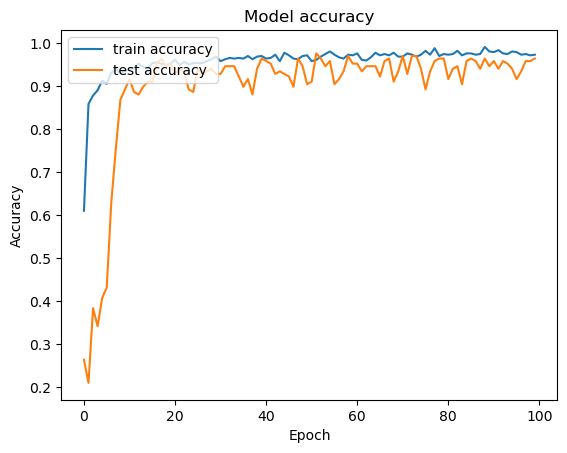

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 0.8268 
Test accuracy: 96.41%
